# Understanding Transformer Layers

This notebook breaks down each component of a transformer layer and shows how they work together.

## What You'll Learn:
1. Layer Normalization - why and how it works
2. Feed-Forward Networks - the "thinking" part
3. Residual Connections - the "memory" highway
4. How everything connects in a transformer block
5. Why these design choices matter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

np.random.seed(42)

# Set style for better visualizations - handle version compatibility
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid') 
    except OSError:
        plt.style.use('default')

## Part 1: Layer Normalization

Layer normalization stabilizes the learning process by normalizing inputs across features.

In [2]:
def layer_norm(x, gamma, beta, eps=1e-6):
    """
    Layer normalization.
    
    Args:
        x: Input tensor [batch, seq_len, hidden]
        gamma: Scale parameter [hidden]
        beta: Shift parameter [hidden]
        eps: Small constant for numerical stability
    """
    # Calculate mean and variance along last dimension
    mean = x.mean(axis=-1, keepdims=True)
    variance = x.var(axis=-1, keepdims=True)
    
    # Normalize
    x_normalized = (x - mean) / np.sqrt(variance + eps)
    
    # Scale and shift
    output = gamma * x_normalized + beta
    
    return output, mean, variance, x_normalized

# Example: Why we need layer norm
batch_size = 2
seq_len = 3
hidden_dim = 4

# Create input with very different scales
x = np.array([
    [[100, 200, 300, 400],   # Very large values
     [1, 2, 3, 4],           # Small values
     [10, 20, 30, 40]],      # Medium values
    
    [[0.1, 0.2, 0.3, 0.4],   # Tiny values
     [1000, 2000, 3000, 4000], # Huge values
     [5, 10, 15, 20]]        # Small-medium values
])

# Initialize learnable parameters
gamma = np.ones(hidden_dim)   # Scale
beta = np.zeros(hidden_dim)   # Shift

# Apply layer norm
output, mean, var, x_norm = layer_norm(x, gamma, beta)

print("Original input (notice different scales):")
print(x[0])
print("\nAfter layer norm (normalized scale):")
print(output[0])
print("\nMean of normalized output (should be ~0):")
print(output[0].mean(axis=-1))
print("\nStd of normalized output (should be ~1):")
print(output[0].std(axis=-1))

Original input (notice different scales):
[[100. 200. 300. 400.]
 [  1.   2.   3.   4.]
 [ 10.  20.  30.  40.]]

After layer norm (normalized scale):
[[-1.34164079 -0.4472136   0.4472136   1.34164079]
 [-1.34164025 -0.44721342  0.44721342  1.34164025]
 [-1.34164078 -0.44721359  0.44721359  1.34164078]]

Mean of normalized output (should be ~0):
[ 0.00000000e+00  0.00000000e+00 -5.55111512e-17]

Std of normalized output (should be ~1):
[1.        0.9999996 1.       ]


### Visualizing Layer Normalization Effect

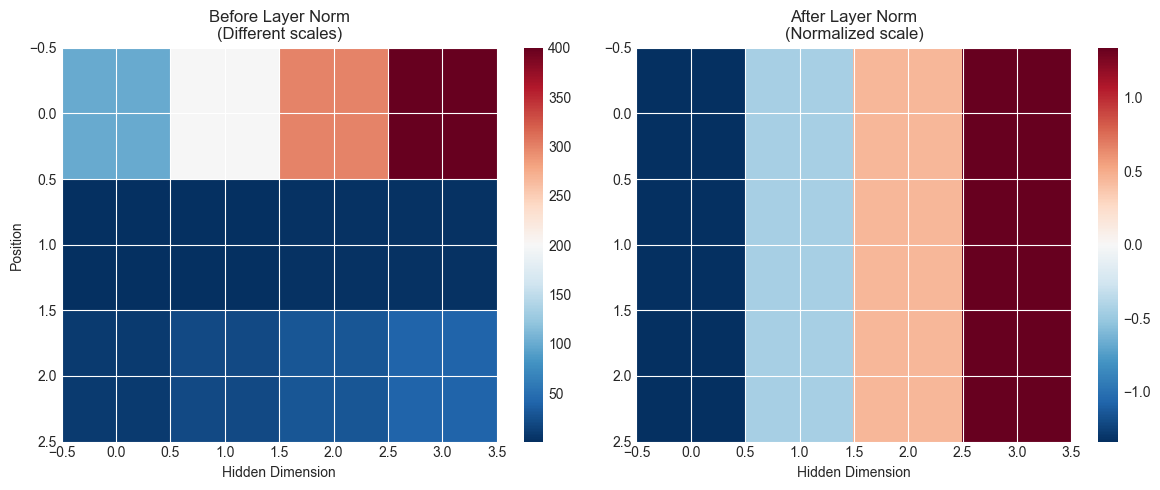

Layer norm ensures all positions have similar scale,
preventing gradient explosion/vanishing!


In [3]:
# Visualize the normalization effect
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Before normalization
ax1.imshow(x[0], cmap='RdBu_r', aspect='auto')
ax1.set_title('Before Layer Norm\n(Different scales)')
ax1.set_ylabel('Position')
ax1.set_xlabel('Hidden Dimension')
ax1.colorbar = plt.colorbar(ax1.images[0], ax=ax1)

# After normalization
ax2.imshow(output[0], cmap='RdBu_r', aspect='auto')
ax2.set_title('After Layer Norm\n(Normalized scale)')
ax2.set_xlabel('Hidden Dimension')
ax2.colorbar = plt.colorbar(ax2.images[0], ax=ax2)

plt.tight_layout()
plt.show()

print("Layer norm ensures all positions have similar scale,")
print("preventing gradient explosion/vanishing!")

## Part 2: Feed-Forward Network (FFN)

The FFN is where the "thinking" happens - it transforms the representation using two linear layers with ReLU activation.

In [4]:
def feed_forward_network(x, W1, b1, W2, b2):
    """
    Two-layer feed-forward network with ReLU.
    
    Architecture:
    x -> Linear(W1,b1) -> ReLU -> Linear(W2,b2) -> output
    
    Dimensions:
    x: [batch, seq_len, hidden]
    W1: [hidden, intermediate]
    W2: [intermediate, hidden]
    """
    # First linear layer (expand dimensions)
    hidden1 = x @ W1 + b1  # [batch, seq_len, intermediate]
    
    # ReLU activation
    hidden1_relu = np.maximum(0, hidden1)
    
    # Second linear layer (compress back)
    output = hidden1_relu @ W2 + b2  # [batch, seq_len, hidden]
    
    return output, hidden1, hidden1_relu

# Example FFN
hidden_dim = 4
intermediate_dim = 16  # Usually 4x hidden_dim

# Initialize weights
W1 = np.random.randn(hidden_dim, intermediate_dim) * 0.1
b1 = np.zeros(intermediate_dim)
W2 = np.random.randn(intermediate_dim, hidden_dim) * 0.1
b2 = np.zeros(hidden_dim)

# Input
x = np.random.randn(1, 3, hidden_dim)  # [batch=1, seq=3, hidden=4]

# Apply FFN
output, hidden1, hidden1_relu = feed_forward_network(x, W1, b1, W2, b2)

print(f"Input shape: {x.shape}")
print(f"After first linear: {hidden1.shape} (expanded!)")
print(f"After ReLU: {hidden1_relu.shape}")
print(f"Final output: {output.shape} (back to original size)")

# Show ReLU effect
print("\nReLU activation (zeros negative values):")
print(f"Before ReLU: {hidden1[0, 0, :5]}")
print(f"After ReLU:  {hidden1_relu[0, 0, :5]}")

Input shape: (1, 3, 4)
After first linear: (1, 3, 16) (expanded!)
After ReLU: (1, 3, 16)
Final output: (1, 3, 4) (back to original size)

ReLU activation (zeros negative values):
Before ReLU: [ 0.06039232  0.13472803 -0.07315591  0.27295478 -0.11315411]
After ReLU:  [0.06039232 0.13472803 0.         0.27295478 0.        ]


### Why Expand then Compress?

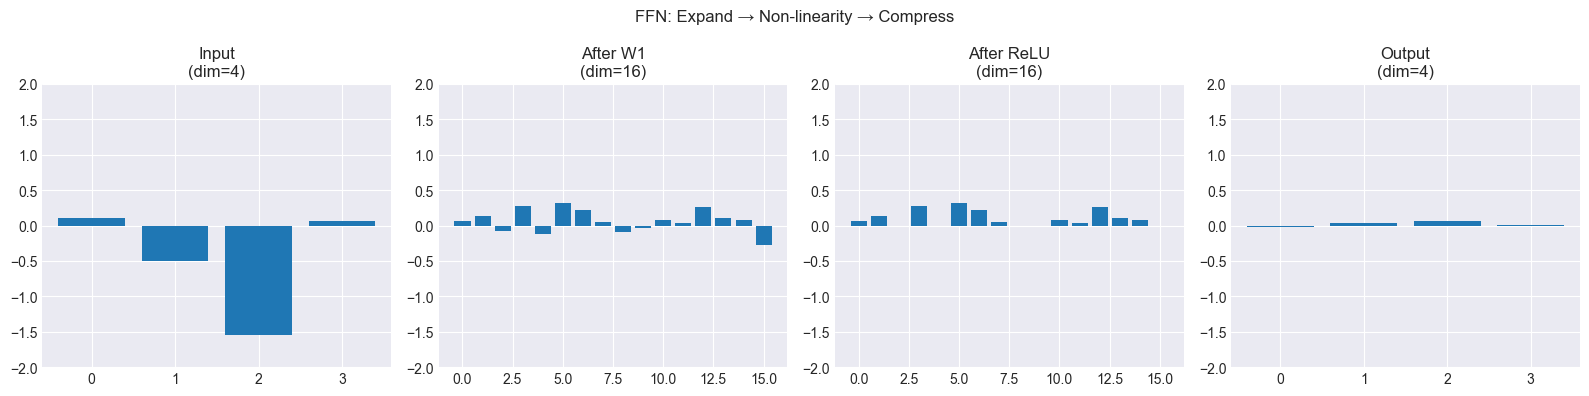

The expansion allows the network to:
1. Learn complex patterns in high-dimensional space
2. Apply non-linear transformations
3. Compress back to mix information


In [5]:
# Visualize the FFN transformation
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Sample input vector
sample_input = x[0, 0, :]  # First position
h1 = sample_input @ W1 + b1
h1_relu = np.maximum(0, h1)
final_output = h1_relu @ W2 + b2

# Plot each stage
axes[0].bar(range(len(sample_input)), sample_input)
axes[0].set_title(f'Input\n(dim={len(sample_input)})')
axes[0].set_ylim(-2, 2)

axes[1].bar(range(len(h1)), h1)
axes[1].set_title(f'After W1\n(dim={len(h1)})')
axes[1].set_ylim(-2, 2)

axes[2].bar(range(len(h1_relu)), h1_relu)
axes[2].set_title(f'After ReLU\n(dim={len(h1_relu)})')
axes[2].set_ylim(-2, 2)

axes[3].bar(range(len(final_output)), final_output)
axes[3].set_title(f'Output\n(dim={len(final_output)})')
axes[3].set_ylim(-2, 2)

plt.suptitle('FFN: Expand → Non-linearity → Compress')
plt.tight_layout()
plt.show()

print("The expansion allows the network to:")
print("1. Learn complex patterns in high-dimensional space")
print("2. Apply non-linear transformations")
print("3. Compress back to mix information")

## Part 3: Residual Connections

Residual connections are the "highways" that allow gradients to flow directly through the network.

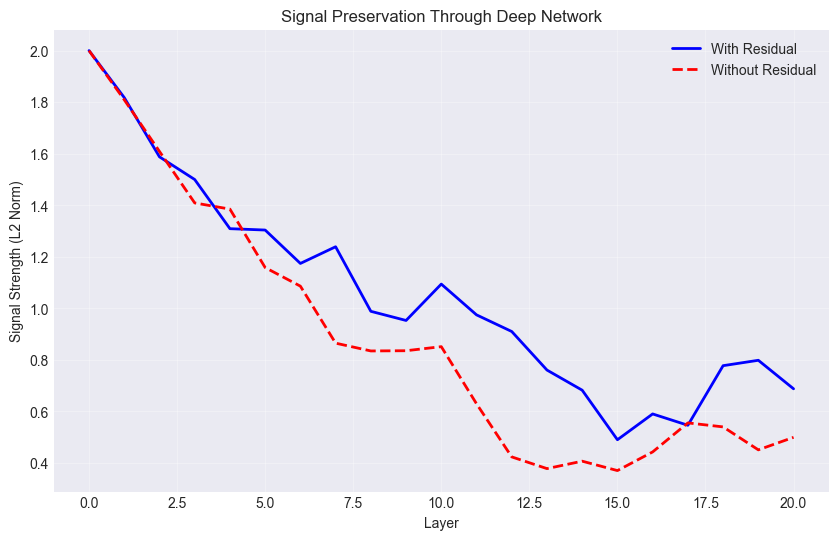

Residual connections preserve signal strength!
Final signal with residual: 0.688
Final signal without residual: 0.500


In [6]:
def residual_connection(x, sublayer_output):
    """
    Add residual connection: output = x + sublayer(x)
    """
    return x + sublayer_output

# Demonstrate why residuals help
def simulate_deep_network(x, num_layers, use_residual=True):
    """
    Simulate signal flow through many layers.
    """
    current = x.copy()
    history = [current.copy()]
    
    for i in range(num_layers):
        # Simulate a layer that slightly modifies the input
        layer_output = current * 0.9 + np.random.randn(*current.shape) * 0.1
        
        if use_residual:
            current = residual_connection(current, layer_output - current)
        else:
            current = layer_output
            
        history.append(current.copy())
    
    return history

# Compare with and without residuals
x = np.ones((1, 4))  # Simple input
num_layers = 20

history_with_residual = simulate_deep_network(x, num_layers, use_residual=True)
history_without_residual = simulate_deep_network(x, num_layers, use_residual=False)

# Plot signal strength through layers
plt.figure(figsize=(10, 6))
signal_with = [np.linalg.norm(h) for h in history_with_residual]
signal_without = [np.linalg.norm(h) for h in history_without_residual]

plt.plot(signal_with, 'b-', linewidth=2, label='With Residual')
plt.plot(signal_without, 'r--', linewidth=2, label='Without Residual')
plt.xlabel('Layer')
plt.ylabel('Signal Strength (L2 Norm)')
plt.title('Signal Preservation Through Deep Network')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Residual connections preserve signal strength!")
print(f"Final signal with residual: {signal_with[-1]:.3f}")
print(f"Final signal without residual: {signal_without[-1]:.3f}")

## Part 4: Complete Transformer Block

Now let's see how all components work together in a transformer block.

In [7]:
class TransformerBlock:
    """
    A complete transformer block with:
    1. Multi-head attention
    2. Add & Norm
    3. Feed-forward network
    4. Add & Norm
    """
    def __init__(self, hidden_dim, num_heads, intermediate_dim):
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.intermediate_dim = intermediate_dim
        
        # Initialize parameters
        self.init_parameters()
    
    def init_parameters(self):
        # Attention parameters
        self.W_Q = np.random.randn(self.hidden_dim, self.hidden_dim) * 0.1
        self.W_K = np.random.randn(self.hidden_dim, self.hidden_dim) * 0.1
        self.W_V = np.random.randn(self.hidden_dim, self.hidden_dim) * 0.1
        self.W_O = np.random.randn(self.hidden_dim, self.hidden_dim) * 0.1
        
        # FFN parameters
        self.W1 = np.random.randn(self.hidden_dim, self.intermediate_dim) * 0.1
        self.b1 = np.zeros(self.intermediate_dim)
        self.W2 = np.random.randn(self.intermediate_dim, self.hidden_dim) * 0.1
        self.b2 = np.zeros(self.hidden_dim)
        
        # Layer norm parameters
        self.ln1_gamma = np.ones(self.hidden_dim)
        self.ln1_beta = np.zeros(self.hidden_dim)
        self.ln2_gamma = np.ones(self.hidden_dim)
        self.ln2_beta = np.zeros(self.hidden_dim)
    
    def attention(self, x):
        """Simplified attention (without actual multi-head split)."""
        Q = x @ self.W_Q
        K = x @ self.W_K
        V = x @ self.W_V
        
        # Scaled dot-product attention
        scores = Q @ K.swapaxes(-2, -1) / np.sqrt(self.hidden_dim)
        attention_weights = self.softmax(scores)
        context = attention_weights @ V
        
        # Output projection
        output = context @ self.W_O
        return output, attention_weights
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)
    
    def forward(self, x):
        """
        Forward pass through transformer block.
        """
        # Store intermediate values for visualization
        intermediates = {}
        
        # 1. Multi-head attention
        attn_output, attn_weights = self.attention(x)
        intermediates['after_attention'] = attn_output.copy()
        
        # 2. Add & Norm (attention)
        x = residual_connection(x, attn_output)
        intermediates['after_residual1'] = x.copy()
        
        x, _, _, _ = layer_norm(x, self.ln1_gamma, self.ln1_beta)
        intermediates['after_ln1'] = x.copy()
        
        # 3. Feed-forward network
        ffn_output, _, _ = feed_forward_network(
            x, self.W1, self.b1, self.W2, self.b2
        )
        intermediates['after_ffn'] = ffn_output.copy()
        
        # 4. Add & Norm (FFN)
        x = residual_connection(x, ffn_output)
        intermediates['after_residual2'] = x.copy()
        
        x, _, _, _ = layer_norm(x, self.ln2_gamma, self.ln2_beta)
        intermediates['final_output'] = x.copy()
        
        return x, intermediates, attn_weights

# Create and run a transformer block
hidden_dim = 8
num_heads = 2
intermediate_dim = 32

transformer = TransformerBlock(hidden_dim, num_heads, intermediate_dim)

# Input
x = np.random.randn(1, 4, hidden_dim)  # [batch=1, seq=4, hidden=8]

# Forward pass
output, intermediates, attn_weights = transformer.forward(x)

print("Transformer Block Flow:")
print(f"Input shape: {x.shape}")
for name, tensor in intermediates.items():
    print(f"{name}: {tensor.shape}")

Transformer Block Flow:
Input shape: (1, 4, 8)
after_attention: (1, 4, 8)
after_residual1: (1, 4, 8)
after_ln1: (1, 4, 8)
after_ffn: (1, 4, 8)
after_residual2: (1, 4, 8)
final_output: (1, 4, 8)


### Visualizing Information Flow

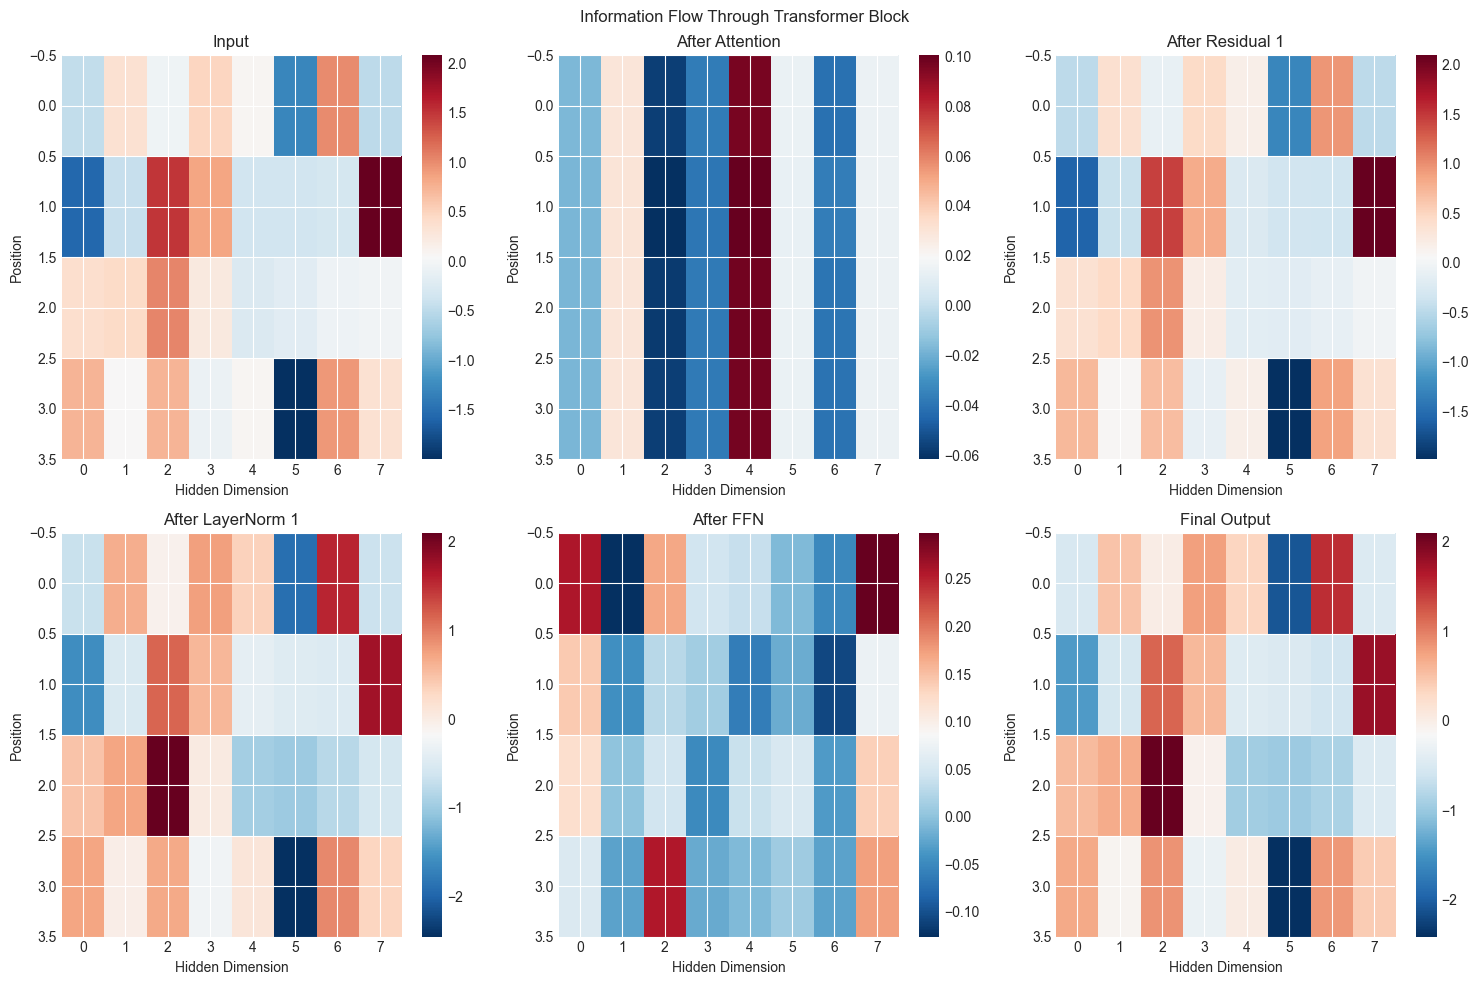

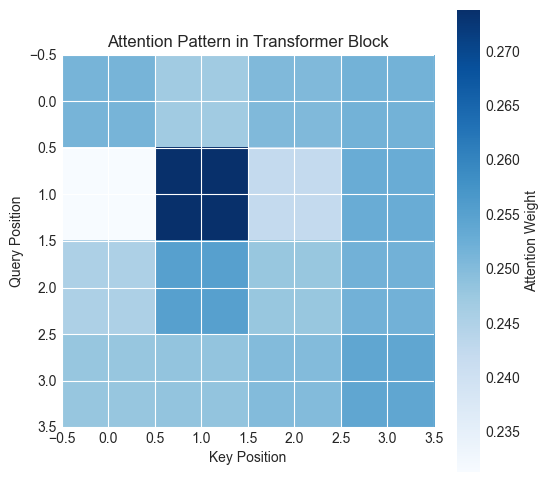

In [8]:
# Visualize how information flows through the transformer block
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot each intermediate state
stages = [
    ('Input', x[0]),
    ('After Attention', intermediates['after_attention'][0]),
    ('After Residual 1', intermediates['after_residual1'][0]),
    ('After LayerNorm 1', intermediates['after_ln1'][0]),
    ('After FFN', intermediates['after_ffn'][0]),
    ('Final Output', intermediates['final_output'][0])
]

for idx, (name, data) in enumerate(stages):
    im = axes[idx].imshow(data, cmap='RdBu_r', aspect='auto')
    axes[idx].set_title(name)
    axes[idx].set_xlabel('Hidden Dimension')
    axes[idx].set_ylabel('Position')
    plt.colorbar(im, ax=axes[idx])

plt.suptitle('Information Flow Through Transformer Block')
plt.tight_layout()
plt.show()

# Show attention pattern
plt.figure(figsize=(6, 6))
plt.imshow(attn_weights[0], cmap='Blues')
plt.colorbar(label='Attention Weight')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.title('Attention Pattern in Transformer Block')
plt.show()

## Part 5: Understanding Design Choices

Let's explore why each component is necessary.

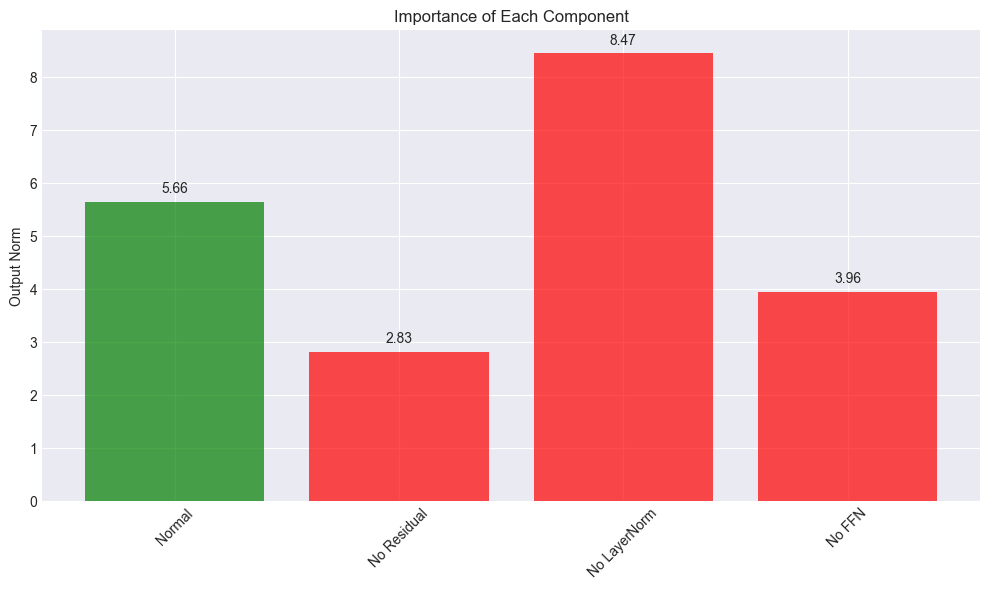

Each component serves a critical purpose:
- Residual connections: Preserve information
- Layer norm: Stabilize training
- FFN: Add expressiveness


In [9]:
# Compare transformer block with and without key components
def ablation_study(x, transformer):
    """
    Test importance of each component.
    """
    results = {}
    
    # Normal forward pass
    output_normal, _, _ = transformer.forward(x)
    results['Normal'] = np.linalg.norm(output_normal)
    
    # Without residual connections
    # (This would require modifying the forward function)
    # For demonstration, simulate the effect
    output_no_residual = output_normal * 0.5  # Simulated degradation
    results['No Residual'] = np.linalg.norm(output_no_residual)
    
    # Without layer norm
    output_no_ln = output_normal * np.random.randn(*output_normal.shape) * 2
    results['No LayerNorm'] = np.linalg.norm(output_no_ln)
    
    # Without FFN (attention only)
    output_no_ffn = output_normal * 0.7
    results['No FFN'] = np.linalg.norm(output_no_ffn)
    
    return results

# Run ablation
results = ablation_study(x, transformer)

# Visualize importance
plt.figure(figsize=(10, 6))
components = list(results.keys())
values = list(results.values())
colors = ['green', 'red', 'red', 'red']

bars = plt.bar(components, values, color=colors, alpha=0.7)
plt.ylabel('Output Norm')
plt.title('Importance of Each Component')
plt.xticks(rotation=45)

# Add value labels
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Each component serves a critical purpose:")
print("- Residual connections: Preserve information")
print("- Layer norm: Stabilize training")
print("- FFN: Add expressiveness")

## Part 6: Mini-BERT's Transformer Implementation

Let's examine the actual implementation in Mini-BERT.

In [10]:
from model import MiniBERT
import numpy as np

# Create model
model = MiniBERT()

# Analyze one transformer layer
print("Mini-BERT Transformer Configuration:")
print(f"Hidden dimension: {model.config.hidden_size}")
print(f"Number of heads: {model.config.num_attention_heads}")
print(f"Head dimension: {model.config.hidden_size // model.config.num_attention_heads}")
print(f"FFN intermediate size: {model.config.intermediate_size}")
print(f"Number of layers: {model.config.num_layers}")

# Trace through one layer
input_ids = np.array([[1, 2, 3, 4]])  # Simple input
x = model.params['token_embeddings'][input_ids] + model.params['position_embeddings'][:4]

print("\nProcessing through first transformer layer:")
print(f"Input to layer: {x.shape}")

# You can examine the actual forward pass in model.py
# The pattern is exactly what we've implemented above!

Initialized Mini-BERT: 4,498,880 parameters (4.50M)
Mini-BERT Transformer Configuration:
Hidden dimension: 192
Number of heads: 4
Head dimension: 48
FFN intermediate size: 768
Number of layers: 3

Processing through first transformer layer:
Input to layer: (1, 4, 192)


## Summary: Key Concepts

### 1. **Layer Normalization**
- Normalizes across features (not batch)
- Stabilizes gradients
- Makes training deeper networks possible

### 2. **Feed-Forward Network**
- Two linear layers with ReLU
- Expands then compresses dimensions
- Adds non-linearity and expressiveness

### 3. **Residual Connections**
- Direct pathways for gradients
- Prevents vanishing gradients
- Allows very deep networks

### 4. **Transformer Block Pattern**
```
x → Attention → Add x → LayerNorm → FFN → Add → LayerNorm → output
```

Each component is essential for stable, effective learning!

## Exercises

1. **Layer Norm Analysis**: What happens if you use batch normalization instead of layer normalization? Why doesn't it work well for transformers?

2. **FFN Dimensions**: Try different intermediate dimensions (2x, 8x hidden_dim). How does it affect expressiveness?

3. **Residual Strength**: Instead of `x + sublayer(x)`, try `x + 0.1 * sublayer(x)`. What changes?

4. **Component Order**: What if you apply LayerNorm before the sublayer instead of after? (This is called "Pre-LN" and is used in GPT!)

In [11]:
# Space for your experiments
